In [1]:
%matplotlib inline
import numpy as np
import math
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from decimal import Decimal
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
import sys
import glob
import os
from shutil import copyfile
import subprocess

#path = 'C:\\WINDOWS\\Fonts\\BOOKOS.TTF'
#prop = fm.FontProperties(fname=path)
#plt.rcParams['font.family'] = prop.get_name()
plt.style.use('ggplot')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}',r'\usepackage{xfrac}']

In [2]:
fine = np.arange(0.05,1.00,0.05)
coarse = np.arange(1.00,2.1,0.1)
k_list = list(fine)+list(coarse)
print(k_list)
print(len(k_list))
print(fine)
print(coarse)
print(len(fine))
print(len(coarse))

[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.6500000000000001, 0.7000000000000001, 0.7500000000000001, 0.8, 0.8500000000000001, 0.9000000000000001, 0.9500000000000001, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000004, 1.5000000000000004, 1.6000000000000005, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001]
30
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
19
11


In [2]:
char = ["B","D","H"]
ky_list = np.arange(0.05,2,0.1)

L_ref = 0.75434953
T_ref = 1000
mi_ref = 1.6724e-27 #proton mass in kg
B_ref = 2.1650553 #in Tesla
mi_ref = 1.67236232e-27
joule_conversion = 1.6022e-19
m_i = 2*mi_ref #ion mass
e = 1.6022e-19 #electron charge in Cb
V_ref = np.sqrt((joule_conversion*T_ref)/mi_ref)
omega_ref = (e*B_ref)/mi_ref
rho_ref = V_ref/omega_ref
omg_norm = (V_ref/L_ref)

omti_dict = {'B':10.42, 'I1':7.815,'I2':15.63, 'D':20.84, 'H':5.21}#L_ref/L_Ti
omte_dict = {'B':28.21, 'I1':21.16, 'I2':42.32, 'D':56.42, 'H':14.1}#L_ref/L_Te
omn_dict = {'B':32.01, 'I1':24.00, 'I2':48.02,'D':64.02, 'H':16.00}#L_ref/L_n

In [3]:
def Larmor_radius(T_i):
    om_cycl = (e*B_ref)/m_i
    v_ti = np.sqrt((2.*joule_conversion*T_i)/m_i)
    rho_i = v_ti/om_cycl
    return rho_i

def Sound_radius(T_e):
    om_cycl = (e*B_ref)/m_i
    v_ts = np.sqrt((2.*joule_conversion*T_e)/m_i)
    rho_s = v_ts/om_cycl
    return rho_s

def omega_star(T,k_y,L_n,L_T):
    omega = (T*joule_conversion*k_y)/(e*B_ref*L_n) + (T*joule_conversion*k_y)/(e*B_ref*L_T)
    freq = (1./(2.*math.pi))*omega
    return omega

In [4]:
Larmor_radius(475)

0.0020569068766479338

In [5]:
Sound_radius(444)

0.001988654376705643

In [6]:
'''Doppler Shift to the plasma frame.'''
omega_sim = -640000*(2.*math.pi)#(cycl/sec)
k_perp = 122#(cycl/m)
V_phase = omega_sim/k_perp
V_pol = -1.25e4
V_plasma_frame = V_phase-V_pol
omega_plfr = V_plasma_frame*k_perp
#print((V_phase*k_perp)/(2.*math.pi),(V_plasma_frame*k_perp)/(2.*math.pi))
print(omega_plfr)
#print(omega_plfr*(2.*math.pi))

-2496238.5965949353


In [7]:
print(omega_star(33.55,0.22/Larmor_radius(88),(1./54.7)*0.269,(1./97.15)*0.269))

2173699.805888398


In [8]:
'''Ideal MHD growth rate'''
def g_mhd():
    R = 0.9 #(m)
    T_i = 88 #(eV)
    T_e = 33.5 #(eV)
    tau = T_i/T_e
    L_n = 0.0049
    L_Ti = 0.0058
    L_Te = 0.0028
    c_s = np.sqrt((T_e*joule_conversion)/m_i)
    L_p = 1./(1./L_n + (1./(1.+1./tau))*(1./L_Ti)+(1./(1.+tau))*1./L_Te)
    gamma_mhd = np.sqrt((2.*np.power(c_s,2))/(R*L_p))
    return gamma_mhd

In [9]:
g_mhd()

1234600.0617292041

In [20]:
def all_freq():
    R = 2
    rho_i = Larmor_radius(475)
    T_i = 475
    T_e = 444.5
    tau = T_i/T_e
    krho_sim = 0.246
    omega_sim = -640000*(2.*math.pi)
    c_s = np.sqrt((T_e*joule_conversion)/m_i)
    #print(c_s)
    for x in range(3):
        for y in range(3):
            for z in range(3):
                L_n = (1./omn_dict[char[x]])*L_ref
                L_Ti = (1./omti_dict[char[y]])*L_ref
                L_Te = (1./omte_dict[char[z]])*L_ref
                L_p = 1./(1./L_n + (1./(1.+1./tau))*(1./L_Ti)+(1./(1.+tau))*1./L_Te)
                
                om_mhd = np.sqrt((2.*np.power(c_s,2))/(R*L_p))
                om_i_star = []
                om_e_star = []
                ky = []
                for k in range(len(ky_list)):
                    om_i_star.append(omega_star(T_i,k/rho_i,L_n,L_Ti))
                    om_e_star.append(-omega_star(T_e,k/rho_i,L_n,L_Te))
                    ky.append(k)
                #print(r"%s%s%s" %(char[x],char[y],char[z]))
                #print(r"$\omega_{MHD}$ = ",om_mhd)
                fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
                plt.subplots_adjust(wspace = 0.8)
                plt.suptitle(r"%s%s%s, $\psi = 0.935$, $\omega_{MHD} = %.2E\, \left(\frac{1}{s}\right)$" %(char[x],char[y],char[z],om_mhd))
                #ax1.set_title(r"%s%s%s, $\psi = 0.935$" %(char[x],char[y],char[z]))    
                ax1.plot(ky[:],om_i_star[:])
                ax1.plot(krho_sim, omega_plfr,"*")
                ax1.set_xlim(0.0,2.0)
                ax1.set_ylim(0.0,5e6)
                ax1.set_xlabel(r"$k_y \rho_i$")
                ax1.set_ylabel(r"$\omega_{\ast,i}\,\left(\frac{cycl.}{sec}\right)$")
                ax1.yaxis.set_major_formatter(FormatStrFormatter(('%.2e')))
                ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
                ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
                ax1.yaxis.set_minor_locator(plt.MaxNLocator(50))
                ax1.xaxis.set_minor_locator(plt.MaxNLocator(20))
                ax1.grid(which = 'major',linestyle='-')
                #plt.show()
                #plt.savefig(trgt+"figures/%s%s%s_omi.png" %(char[x],char[y],char[z]), bbox_inches='tight')
                #plt.close()
                #ax2.set_title(r"%s%s%s, $\psi = 0.935$" %(char[x],char[y],char[z])) 
                ax2.plot(ky[:],om_e_star[:])
                ax2.plot(krho_sim, omega_plfr,"*")
                ax2.set_xlim(0.0,2.0)
                ax2.set_ylim(0.0,-5e6)
                ax2.set_xlabel(r"$k_y \rho_i$")
                ax2.set_ylabel(r"$\omega_{\ast,e}\,\left(\frac{cycl.}{sec}\right)$")
                ax2.yaxis.set_major_formatter(FormatStrFormatter(('%.2e')))
                ax2.yaxis.set_major_locator(plt.MaxNLocator(10))
                ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
                ax2.yaxis.set_minor_locator(plt.MaxNLocator(50))
                ax2.xaxis.set_minor_locator(plt.MaxNLocator(20))
                ax2.grid(which = 'major',linestyle='-')
                #ax2.grid(which = 'minor',linestyle='--')
                #plt.show()
                #plt.savefig(trgt+"figures/%s%s%s_ome.png" %(char[x],char[y],char[z]), bbox_inches='tight')
                #plt.close()

C:\Users\giann\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


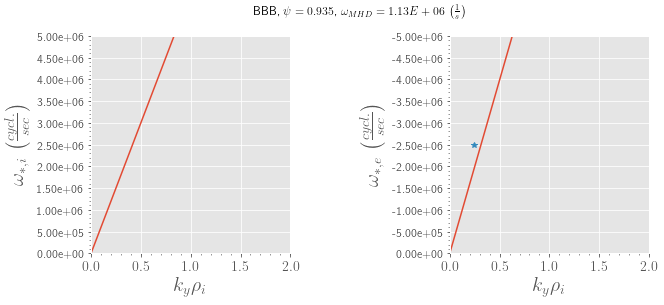

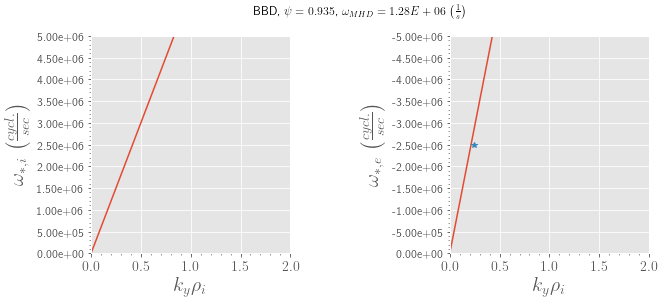

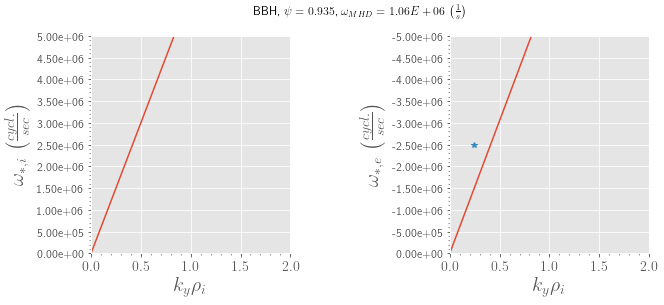

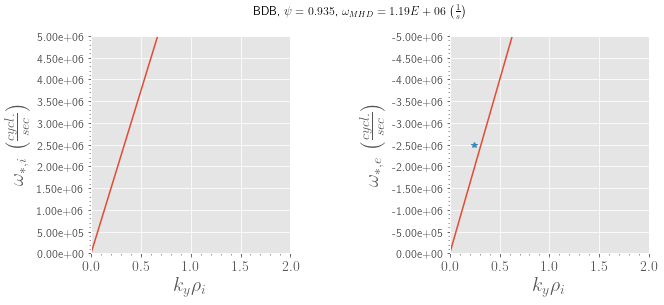

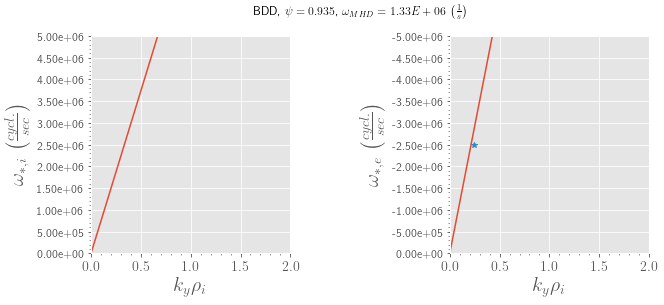

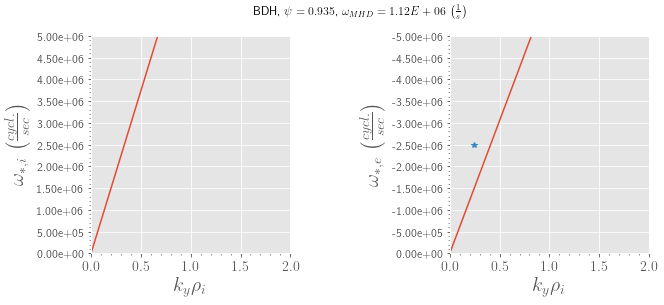

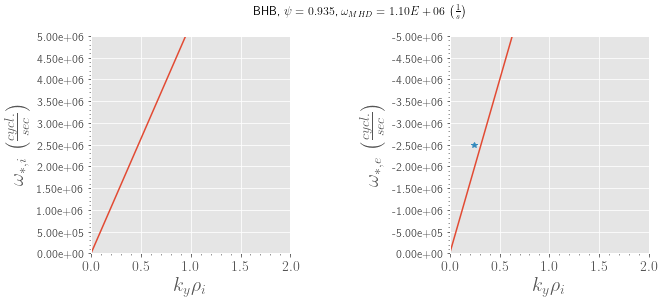

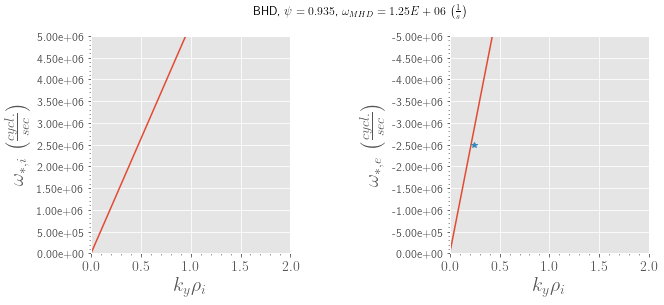

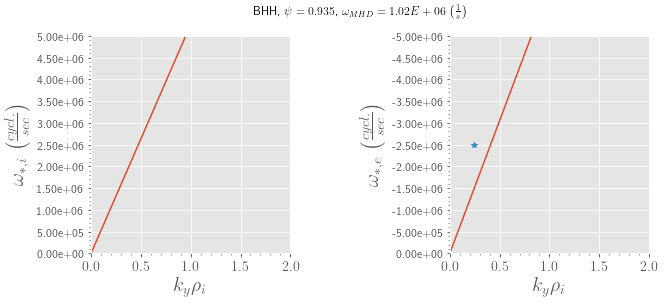

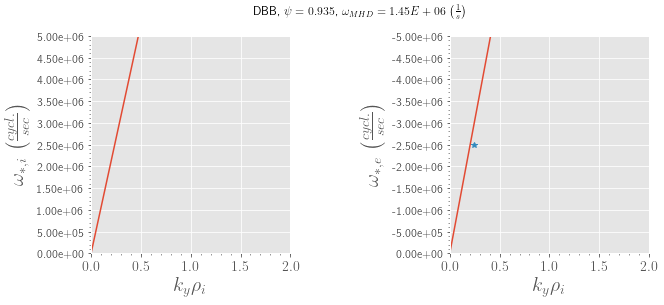

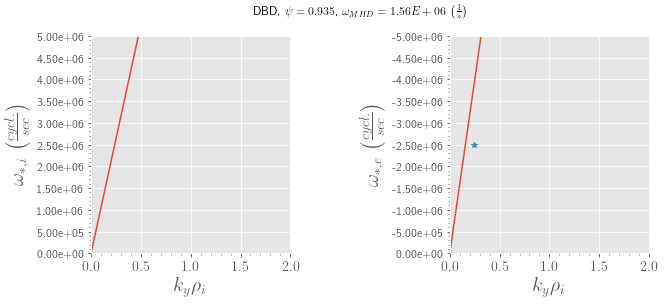

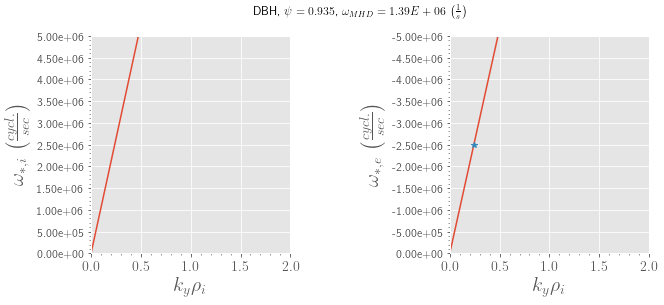

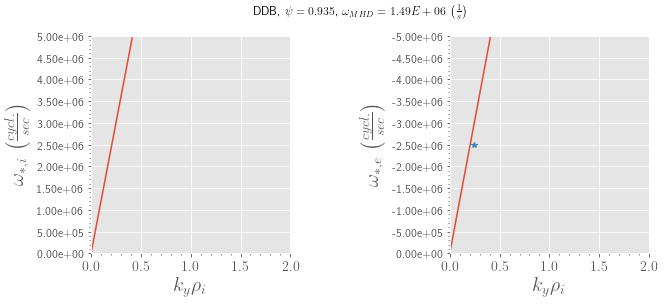

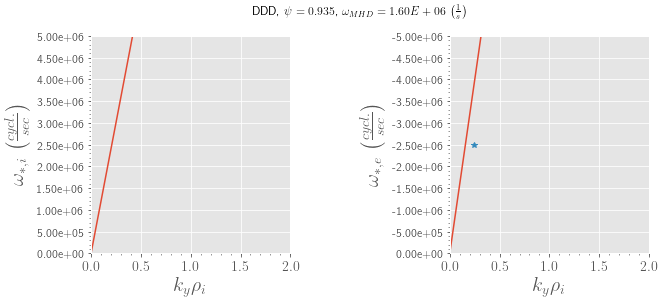

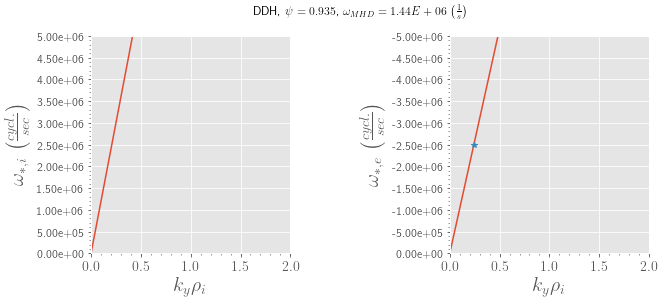

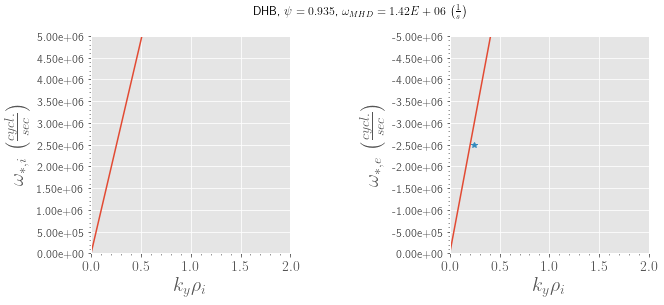

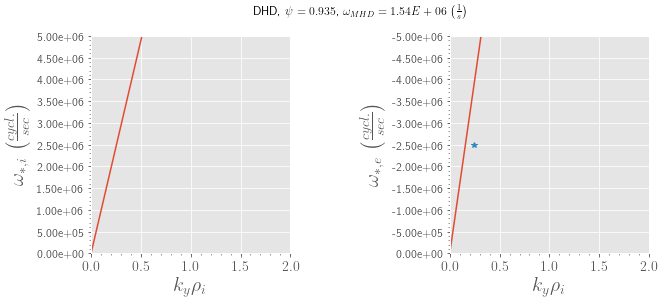

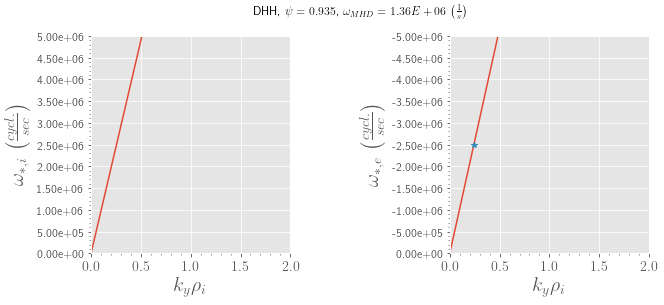

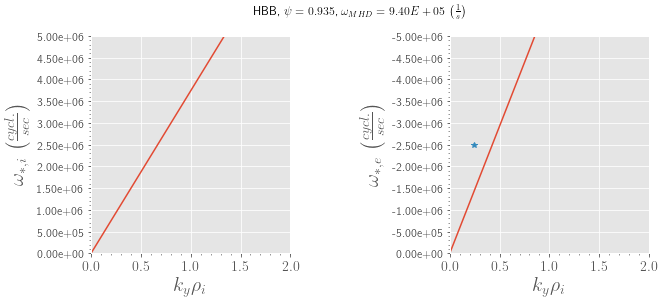

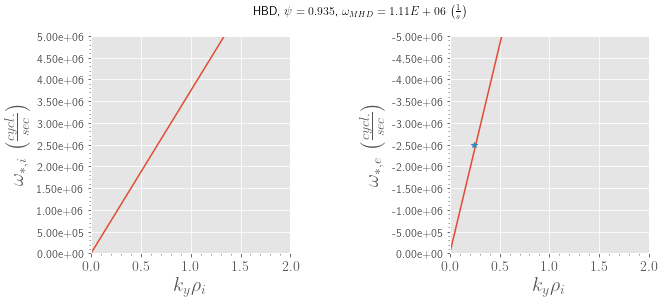

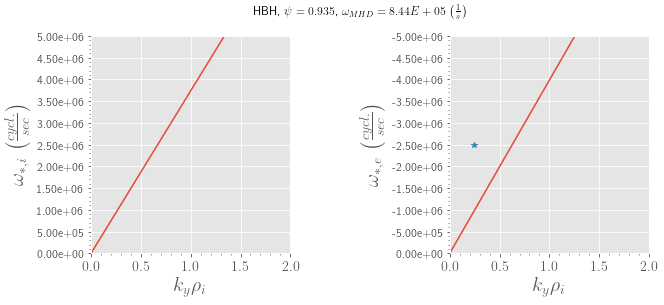

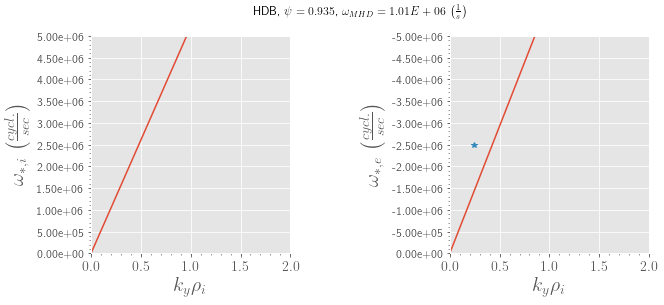

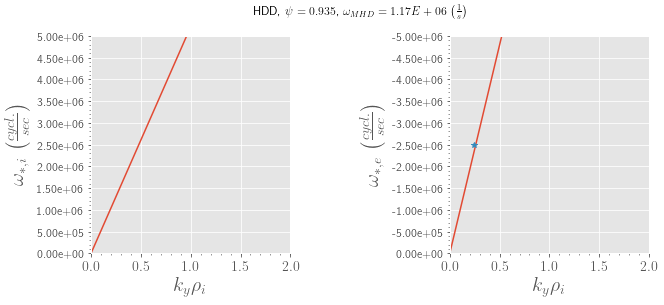

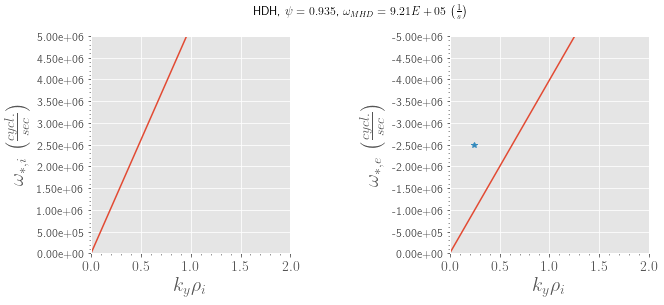

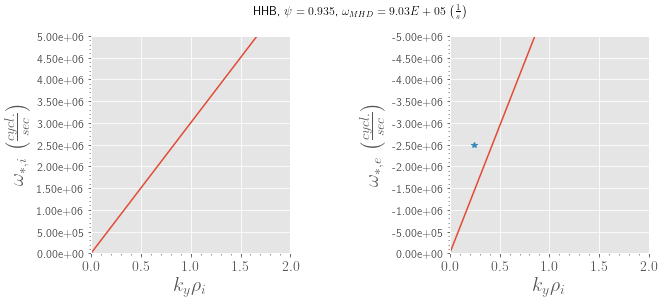

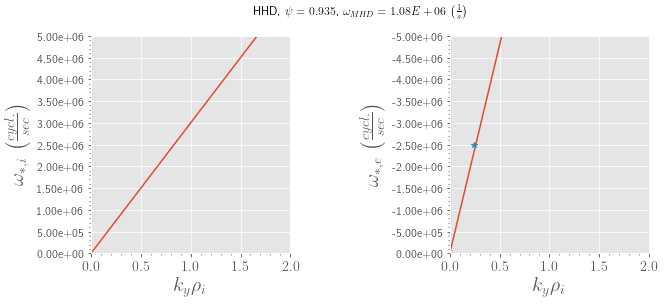

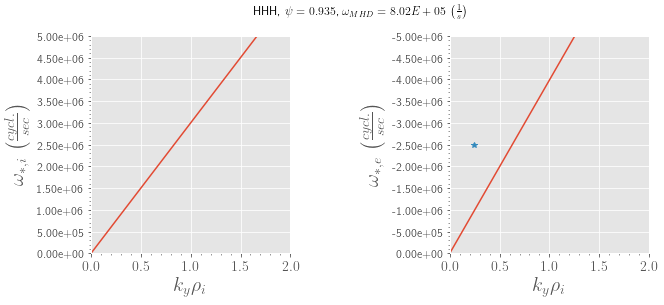

In [21]:
all_freq()

In [61]:
from matplotlib.ticker import ScalarFormatter

Text(1.85,-790000,'$\\nabla T_i$')

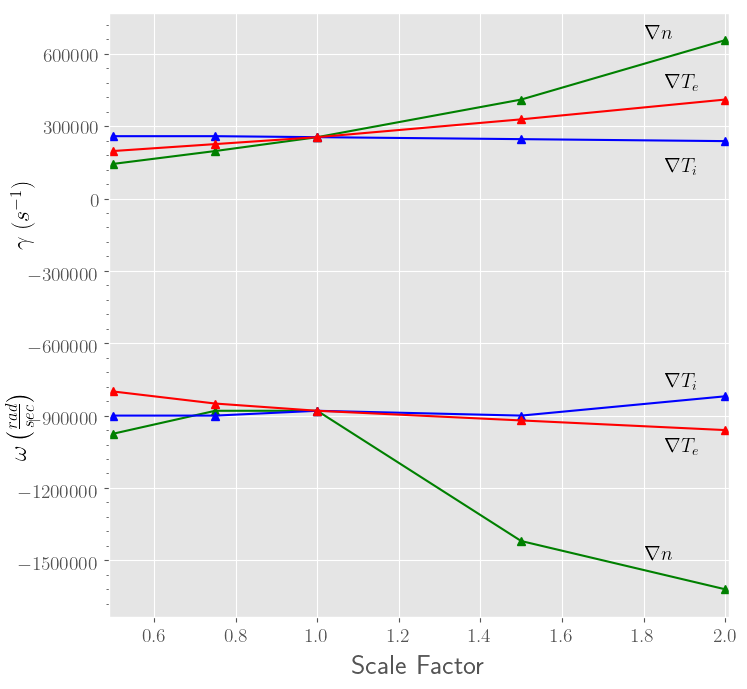

In [10]:
#Data from GENE simulations
T_i = 475
T_e = 444.5

krho_sim = 0.246
f_sim = -640000

om_norm = (V_ref/L_ref)
g_norm = (V_ref/L_ref)

g_grad_n = [0.35,0.48,0.62,1.0,1.60]
g_grad_Ti = [0.63,0.63,0.62,0.60,0.58]
g_grad_Te = [0.48,0.55,0.62,0.8,1.0]
om_grad_n = [-975000,-880000,-880000,-1420000,-1620000]/g_norm
om_grad_Ti = [-900000,-900000,-880000,-900000,-820000]/g_norm
om_grad_Te = [-800000,-850000,-880000,-920000,-960000]/g_norm

rho_i = Larmor_radius(475)
def L_n(x):
    L_n = (1./omn_dict[x])*L_ref
    return L_n
def L_Ti(x):
    L_Ti = (1./omti_dict[x])*L_ref
    return L_Ti 
def L_Te(x):
    L_Te = (1./omte_dict[x])*L_ref
    return L_Te

ome_grad_n=[-omega_star(T_e,krho_sim/rho_i,L_n('H'),L_Te('B')),-omega_star(T_e,krho_sim/rho_i,L_n('I1'),L_Te('B')),-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('B')),-omega_star(T_e,krho_sim/rho_i,L_n('I2'),L_Te('B')),-omega_star(T_e,krho_sim/rho_i,L_n('D'),L_Te('B'))]
ome_grad_Te=[-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('H')),-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('I1')),-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('B')),-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('I2')),-omega_star(T_e,krho_sim/rho_i,L_n('B'),L_Te('D'))]

x_pts = [0.5,0.75,1.0,1.5,2.0]


fig,(ax1) = plt.subplots(1,1,figsize=(8,8),frameon=False, dpi=100)
plt.subplots_adjust(wspace = 0.4)
ax1.plot(x_pts,[y*g_norm for y in g_grad_n],"^-",color='g',label=r'$\nabla n$')
ax1.plot(x_pts,[y*g_norm for y in g_grad_Ti],"^-",color='b',label=r'$\nabla T_i$')
ax1.plot(x_pts,[y*g_norm for y in g_grad_Te],"^-",color='r',label=r'$\nabla T_e$')
trans = ax1.get_yaxis_transform()
ax1.annotate(r"$\omega \left(\frac{rad}{sec}\right)$",xy=(-0.16,-900000),xycoords=trans,fontsize='xx-large',rotation=90)
ax1.annotate(r"$\gamma\; (s^{-1})$",xy=(-0.16,0),xycoords=trans,fontsize='xx-large',rotation=90)
ax1.set_xlabel(r"Scale Factor")
ax1.set_xlim(0.49,2.01)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax1.yaxis.set_major_formatter(FormatStrFormatter(('%f.0')))
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax1.yaxis.set_minor_locator(plt.MaxNLocator(50))
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
#ax1.set_xticks([0.98,2.0,3.0])
#ax1.set_xticklabels(['H','B','D'])
#ax.plot(1.0,f_sim,"*")
ax1.plot(x_pts,[y*om_norm for y in om_grad_n],"^-",color='g',label=r'$\nabla n$')
ax1.plot(x_pts,[y*om_norm for y in om_grad_Ti],"^-",color='b',label=r'$\nabla T_i$')
ax1.plot(x_pts,[y*om_norm for y in om_grad_Te],"^-",color='r',label=r'$\nabla T_e$')
ax1.annotate(r'$\nabla n$', xy=(1.8,660000),fontsize='x-large')
ax1.annotate(r'$\nabla T_e$', xy=(1.85,450000),fontsize='x-large')
ax1.annotate(r'$\nabla T_i$', xy=(1.85,100000),fontsize='x-large')
ax1.annotate(r'$\nabla n$', xy=(1.8,-1500000),fontsize='x-large')
ax1.annotate(r'$\nabla T_e$', xy=(1.85,-1060000),fontsize='x-large')
ax1.annotate(r'$\nabla T_i$', xy=(1.85,-790000),fontsize='x-large')
#ax2.set_title(r'$\omega_{\ast,e}$ drivers')
#ax2.plot(x_pts,[y*(2.*math.pi) for y in ome_grad_n],color = 'g')
#ax2.plot(x_pts,[y*(2.*math.pi) for y in ome_grad_Te],color = 'r')
#ax2.axhline(y=f_sim*(2.*math.pi)- k_perp*V_pol)
#ax2.set_ylabel(r"$\omega_{\ast,e}$",)
#ax2.annotate(r'$\nabla n$', xy=(2.91,-2800000),fontsize='x-large')
#ax2.annotate(r'$\nabla T_e$', xy=(2.85,-3000000),fontsize='x-large')
#ax2.set_xlim(0,2)
#ax2.yaxis.set_major_formatter(FormatStrFormatter(('%d')))
#ax2.yaxis.set_major_locator(plt.MaxNLocator(10))
#ax2.yaxis.set_minor_locator(plt.MaxNLocator(50))
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
#ax2.set_xticks([0.98,2.0,3.0])
#ax2.set_xticklabels(['H','B','D'])


#fig.legend()

In [12]:
print("growth rate (1/s) =", 0.62*om_norm)
print("growth rate (Hz) =", 0.62*om_norm/(2*np.pi))

growth rate (1/s) = 254397.1503159752
growth rate (Hz) = 40488.563981279374


In [11]:
file = open("Drivers(fig.9).txt",'a')
file.write("0.5"+"\t"+"0.75"+"\t"+"1.0"+"\t"+"1.5"+"\t"+"2.0"+"\n")
file.write(str(g_grad_n[0]*g_norm)+"\t"+str(g_grad_n[1]*g_norm)+"\t"+str(g_grad_n[2]*g_norm)+"\t"+str(g_grad_n[3]*g_norm)+"\t"str(g_grad_n[4]*g_norm)+"\t"+"gamma_grad_n"+"\n")
file.write(str(g_grad_Ti[0]*g_norm)+"\t"+str(g_grad_Ti[1]*g_norm)+"\t"+str(g_grad_Ti[2]*g_norm)+"\t"+str(g_grad_Ti[3]*g_norm)+"\t"str(g_grad_Ti[4]*g_norm)+"\t"+"gamma_grad_Ti"+"\n")
file.write(str(g_grad_Te[0]*g_norm)+"\t"+str(g_grad_Te[1]*g_norm)+"\t"+str(g_grad_Te[2]*g_norm)+"\t"+str(g_grad_Te[3]*g_norm)+"\t"+str(g_grad_Te[4]*g_norm)+"\t"+"gamma_grad_Te"+"\n")
file.write(str(om_grad_n[0]*om_norm)+"\t"+str(om_grad_n[1]*om_norm)+"\t"+str(om_grad_n[2]*om_norm)+"\t"+str(om_grad_n[3]*om_norm)+"\t"+str(om_grad_n[4]*om_norm)+"\t"+"omega_grad_n"+"\n")
file.write(str(om_grad_Ti[0]*g_norm)+"\t"+str(om_grad_Ti[1]*g_norm)+"\t"+str(om_grad_Ti[2]*g_norm)+"\t"+str(om_grad_Ti[3]*g_norm)+"\t"+str(om_grad_Ti[4]*g_norm)+"\t"+"omega_grad_Ti"+"\n")
file.write(str(om_grad_Te[0]*om_norm)+"\t"+str(om_grad_Te[1]*om_norm)+"\t"+str(om_grad_Te[2]*om_norm)+"\t"+str(om_grad_Te[3]*om_norm)+"\t"+str(om_grad_Te[4]*om_norm)+"\t"+"omega_grad_Te"+"\n")

file.close()    

SyntaxError: invalid syntax (<ipython-input-11-829cb4fe2a2d>, line 3)